<a href="https://colab.research.google.com/github/anishks07/annmid/blob/master/ANN_LAB_MID_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hopfield

In [ ]:
pip install neurodynex3

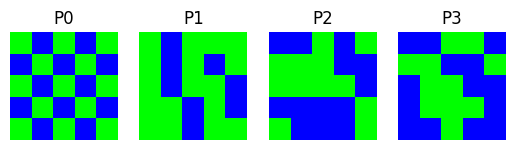

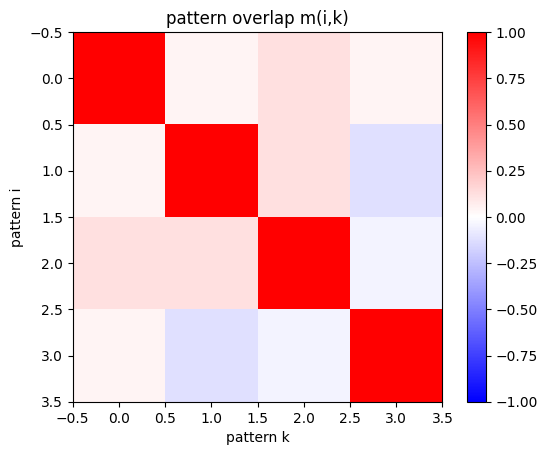

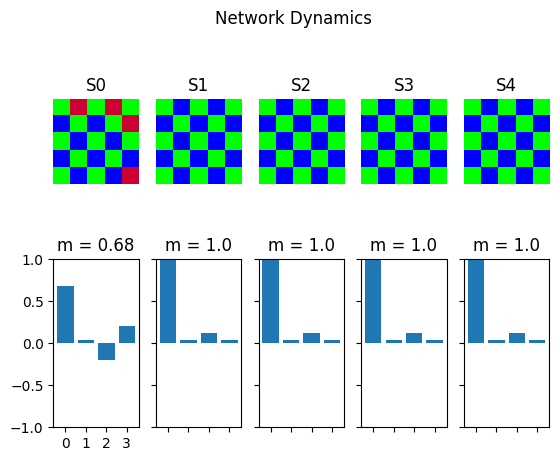

In [4]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
pattern_size = 5
hopfield_net = network.HopfieldNetwork(nr_neurons=pattern_size**2)
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=3, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)
hopfield_net.store_patterns(pattern_list)
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)
states = hopfield_net.run_with_monitoring(nr_steps=4)
states_as_patterns = factory.reshape_patterns(states)
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns,
    pattern_list,
    reference_idx=0,
    suptitle="Network Dynamics"
)

cbow

In [ ]:
pip install tensorflow


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5271 - loss: 0.6931 
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5141 - loss: 0.6930
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5564 - loss: 0.6929
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6156 - loss: 0.6928
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 0.6927
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6117 - loss: 0.6926
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6474 - loss: 0.6925
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6720 - loss: 0.6923
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6699 - loss: 0.6923
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6881 - loss: 0.6920
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6991 - loss: 0.6919
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6887 - loss: 0.6917


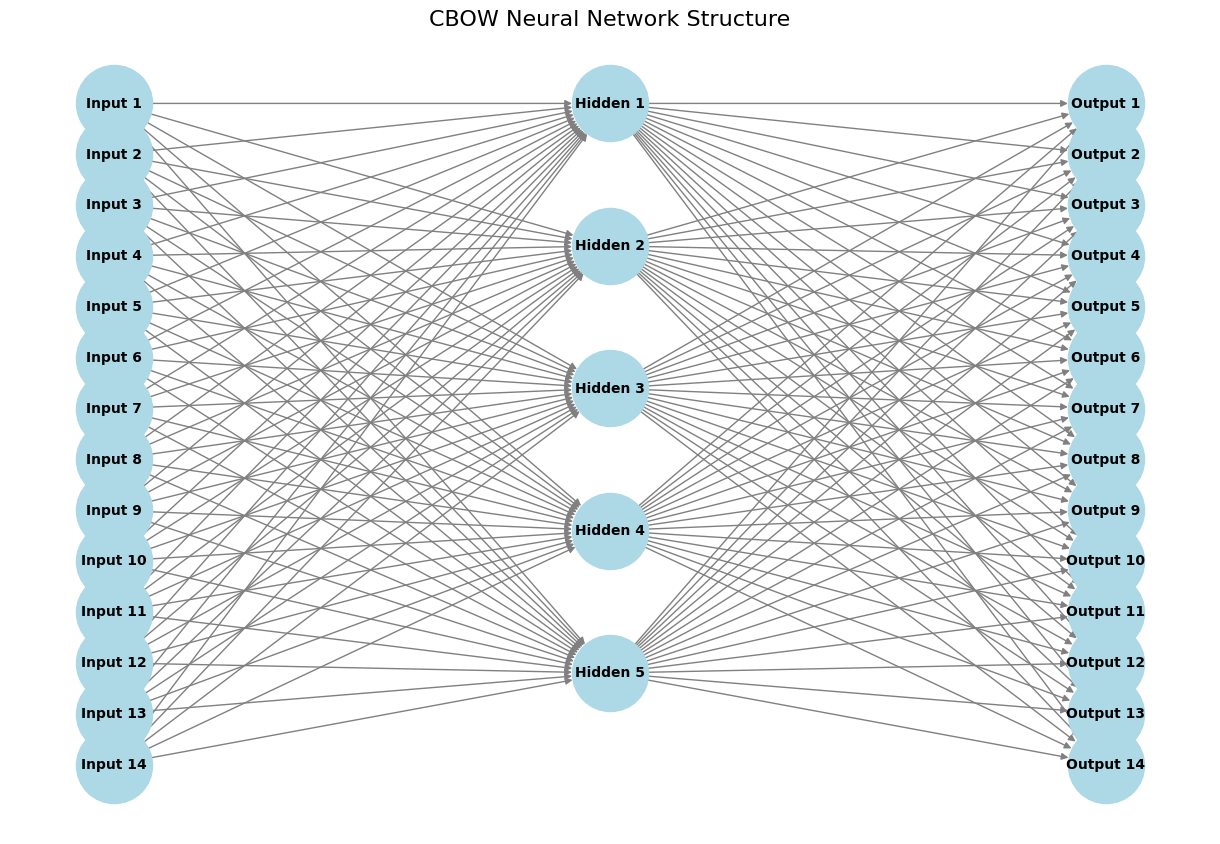

In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import networkx as nx
training_corpus = [
    "the sky is blue",
    "the sun is bright",
    "we can see the sky",
    "the blue sky is beautiful",
    "bright sun shines bright"
]
testing_corpus = [
    "the sky is clear",
    "bright sun and blue sky",
    "we can see bright sun",
    "the sky is endless",
    "the blue sun shines"
]
embedding_dim = 5
window_size = 2
vocab_size = None
def preprocess_corpus(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    word_to_index = tokenizer.word_index
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    global vocab_size
    vocab_size = len(word_to_index) + 1
    return sequences, word_to_index, index_to_word
def generate_skipgrams(sequences, vocab_size, window_size):
    skip_grams = []
    for sequence in sequences:
        pairs, labels = skipgrams(sequence, vocabulary_size=vocab_size, window_size=window_size)
        skip_grams.extend(zip(pairs, labels))
    return skip_grams
train_sequences, word_to_index, index_to_word = preprocess_corpus(training_corpus + testing_corpus)
skip_grams = generate_skipgrams(train_sequences, vocab_size, window_size)
input_target = Input((1,))
input_context = Input((1,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="embedding")
target = embedding(input_target)
context = embedding(input_context)
dot_product = Dot(axes=-1)([target, context])
flatten = Flatten()(dot_product)
output = Dense(1, activation="sigmoid")(flatten)
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
targets, contexts, labels = zip(*[(pair[0], pair[1], label) for pair, label in skip_grams])
targets = np.array(targets, dtype="int32")
contexts = np.array(contexts, dtype="int32")
labels = np.array(labels, dtype="int32")
model.fit([targets, contexts], labels, epochs=100, batch_size=128)
test_sequences, _, _ = preprocess_corpus(testing_corpus)
test_skip_grams = generate_skipgrams(test_sequences, vocab_size, window_size)
correct_predictions = 0
total_predictions = len(test_skip_grams)
for (target, context), label in test_skip_grams:
    prediction = model.predict([np.array([target]), np.array([context])])
    predicted_label = 1 if prediction > 0.5 else 0
    if predicted_label == label:
        correct_predictions += 1
testing_accuracy = (correct_predictions / total_predictions) * 100
print(f"Vocabulary Size: {vocab_size}")
print(f"Testing Accuracy: {testing_accuracy:.2f}%")
def plot_cbows_network(vocab_size, embedding_dim):
    G = nx.DiGraph()
    input_layer = [f"Input {i+1}" for i in range(vocab_size)]
    hidden_layer = [f"Hidden {i+1}" for i in range(embedding_dim)]
    output_layer = [f"Output {i+1}" for i in range(vocab_size)]
    for inp in input_layer:
        for hid in hidden_layer:
            G.add_edge(inp, hid)
    for hid in hidden_layer:
        for out in output_layer:
            G.add_edge(hid, out)
    pos = {}
    for i, node in enumerate(input_layer):
        pos[node] = (0, -i)
    for i, node in enumerate(hidden_layer):
        pos[node] = (1, -i * (vocab_size / embedding_dim))
    for i, node in enumerate(output_layer):
        pos[node] = (2, -i)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("CBOW Neural Network Structure", fontsize=16)
    plt.show()
plot_cbows_network(vocab_size, embedding_dim)

bsb

Stored Patterns (Hebbian Learning):
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0        0.2       -0.4        0.6       -0.8        1.0
1       -0.8        0.6       -0.4        0.2       -1.0

BSB Iterations with Hebbian Weights:
             Node_1    Node_2    Node_3    Node_4    Node_5
Iteration                                                  
0          0.100000 -0.800000  0.600000 -0.200000  0.800000
1          0.894500 -0.047963  0.423542 -0.849958  0.935409
2          0.235376 -0.959742  0.834004 -0.343444  0.976496
3          0.932877 -0.234860  0.461126 -0.902919  0.982762
4          0.358109 -0.944286  0.869036 -0.422720  0.987433
5          0.915611 -0.374430  0.499626 -0.894936  0.988899
6          0.459115 -0.918770  0.870032 -0.496853  0.990728
7          0.893902 -0.480999  0.554141 -0.879436  0.991774
8          0.541606 -0.892365  0.858688 -0.564168  0.992755
9          0.870688 -0.562004  0.607200 -0.860398  0.993421
10         0.605211 -0.866603  0.84

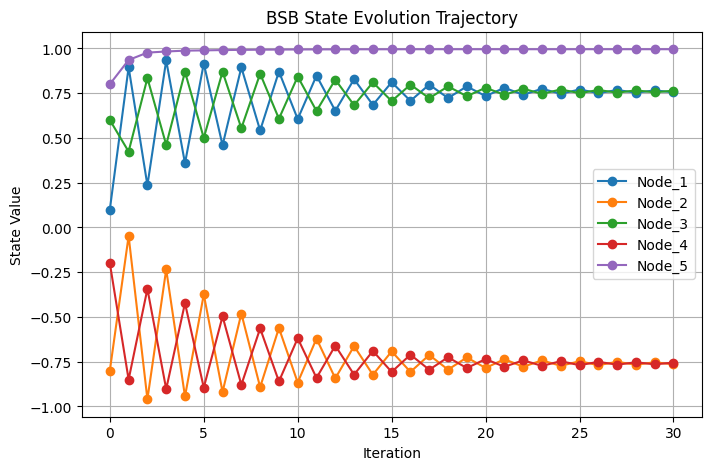

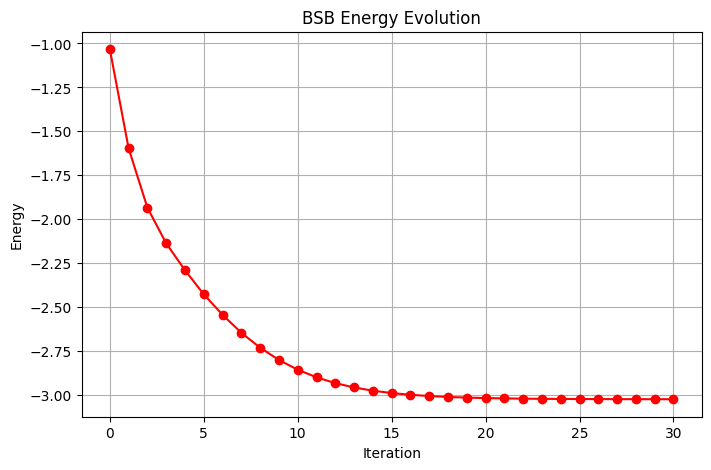

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
patterns = np.array([
    [0.2, -0.4, 0.6, -0.8, 1],        # First pattern
    [-0.8, 0.6, -0.4, 0.2, -1]        # Second pattern
])
W_bsb_hebbian = patterns.T @ patterns
W_bsb_hebbian = W_bsb_hebbian.astype(np.float64)
W_bsb_hebbian -= np.eye(W_bsb_hebbian.shape[0]) * np.max(W_bsb_hebbian)
def bsb_update(x, W, num_iterations=30):
    def tanh_activation(x):
        return np.tanh(x)
    def compute_energy(x, W):
        return -0.5 * x.T @ W @ x
    x_values = [x.copy()]
    energy_values = [compute_energy(x, W)]
    for _ in range(num_iterations):
        x = tanh_activation(W @ x)
        x_values.append(x.copy())
        energy_values.append(compute_energy(x, W))
    return np.array(x_values), np.array(energy_values)
x_test = np.array([0.1, -0.8, 0.6, -0.2, 0.8])  # Slightly noisy version of first pattern
bsb_results, energy_results = bsb_update(x_test, W_bsb_hebbian)
df_bsb_results = pd.DataFrame(bsb_results, columns=[f"Node_{i+1}" for i in range(5)])
df_bsb_results.index.name = "Iteration"
df_energy_results = pd.DataFrame(energy_results, columns=["Energy"])
df_energy_results.index.name = "Iteration"
print("Stored Patterns (Hebbian Learning):")
print(pd.DataFrame(patterns, columns=[f"Feature_{i+1}" for i in range(5)]))
print("\nBSB Iterations with Hebbian Weights:")
print(df_bsb_results)
print("\nEnergy Evolution:")
print(df_energy_results)
def plot_state_evolution(df):
    plt.figure(figsize=(8, 5))
    for column in df.columns:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    plt.xlabel("Iteration")
    plt.ylabel("State Value")
    plt.title("BSB State Evolution Trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_energy_evolution(df):
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df["Energy"], marker='o', linestyle='-', color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("BSB Energy Evolution")
    plt.grid(True)
    plt.show()
plot_state_evolution(df_bsb_results)
plot_energy_evolution(df_energy_results)


simulated annealing


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import random
import math
iris = load_iris()
X = iris.data  # Features
Y = iris.target.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
Y_encoded = encoder.fit_transform(Y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)
input_size = X.shape[1]             # 4 features
hidden_size = 7                     # Hidden layer with 7 neurons
output_size = Y_encoded.shape[1]    # 3 classes
np.random.seed(42)
w1 = np.random.randn(input_size, hidden_size)
b1 = np.random.randn(hidden_size)
w2 = np.random.randn(hidden_size, output_size)
b2 = np.random.randn(output_size)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
def forward_pass(X, w1, b1, w2, b2):
    hidden_layer = sigmoid(np.dot(X, w1) + b1)
    output_layer = softmax(np.dot(hidden_layer, w2) + b2)
    return hidden_layer, output_layer
def compute_loss(Y_pred, Y_true):
    return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / len(Y_true)
def simulated_annealing(X, Y, w1, b1, w2, b2, max_iter=1000, initial_temp=1.0, cooling_rate=0.995):
    temp = initial_temp
    current_w1, current_b1 = w1.copy(), b1.copy()
    current_w2, current_b2 = w2.copy(), b2.copy()
    _, current_output = forward_pass(X, current_w1, current_b1, current_w2, current_b2)
    current_loss = compute_loss(current_output, Y)
    for i in range(max_iter):
        new_w1 = current_w1 + np.random.normal(0, 0.1, current_w1.shape)
        new_b1 = current_b1 + np.random.normal(0, 0.1, current_b1.shape)
        new_w2 = current_w2 + np.random.normal(0, 0.1, current_w2.shape)
        new_b2 = current_b2 + np.random.normal(0, 0.1, current_b2.shape)
        _, new_output = forward_pass(X, new_w1, new_b1, new_w2, new_b2)
        new_loss = compute_loss(new_output, Y)
        if new_loss < current_loss or random.uniform(0, 1) < math.exp((current_loss - new_loss) / temp):
            current_w1, current_b1 = new_w1, new_b1
            current_w2, current_b2 = new_w2, new_b2
            current_loss = new_loss
        temp *= cooling_rate
        if temp < 1e-8:
            break
    return current_w1, current_b1, current_w2, current_b2
w1, b1, w2, b2 = simulated_annealing(X_train, Y_train, w1, b1, w2, b2)
_, Y_pred = forward_pass(X_test, w1, b1, w2, b2)
predictions = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
accuracy = np.mean(predictions == y_true)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

Classification Accuracy: 100.00%
